In [6]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Project/Pothole_detection_final/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/Project/Pothole_detection_final/Normal_road/pothole_image_12736.jpg
/content/drive/MyDrive/Project/Pothole_detection_final/Normal_road/pothole_image_29900.jpg
/content/drive/MyDrive/Project/Pothole_detection_final/Normal_road/pothole_image_11287.jpg
/content/drive/MyDrive/Project/Pothole_detection_final/Normal_road/pothole_image_12545.jpg
/content/drive/MyDrive/Project/Pothole_detection_final/Normal_road/pothole_image_17251.jpg
/content/drive/MyDrive/Project/Pothole_detection_final/Normal_road/pothole_image_444.jpg
/content/drive/MyDrive/Project/Pothole_detection_final/Normal_road/pothole_image_11308.jpg
/content/drive/MyDrive/Project/Pothole_detection_final/Normal_road/pothole_image_29317.jpg
/content/drive/MyDrive/Project/Pothole_detection_final/Normal_road/pothole_image_252.jpg
/content/drive/MyDrive/Project/Pothole_detection_final/Normal_road/pothole_image_12919.jpg
/content/drive/MyDrive/Project/Pothole_dete

Importing all important libraries

In [7]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#!pip install tensorflow
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
#!pip install tensorflow.keras.optimizers 
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
#!pip install tensorflow.keras.utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import InputLayer
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
import keras.preprocessing.image as img
from tensorflow.keras.applications.resnet50 import ResNet50

In [8]:
os.listdir('/content/drive/MyDrive/Project/Pothole_detection_final/')

['Pothole_road', 'Normal_road']

Resizing the images into (256 * 256)


In [9]:
def make_train_data(label,DIR):
    for img in tqdm(os.listdir(DIR)):
        try:
            path = os.path.join(DIR,img)
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

            X.append(np.array(img))
            Z.append(str(label))
        except:
            pass
        
def assign_label(img,label):
    return label

In [10]:
X=[]
Z=[]
IMG_SIZE=256
Normal='/content/drive/MyDrive/Project/Pothole_detection_final/Normal_road'
Pothole='/content/drive/MyDrive/Project/Pothole_detection_final/Pothole_road'

make_train_data('Normal',Normal)
make_train_data('Pothole',Pothole)

100%|██████████| 5854/5854 [02:15<00:00, 43.14it/s] 


Displaying the training data with labels

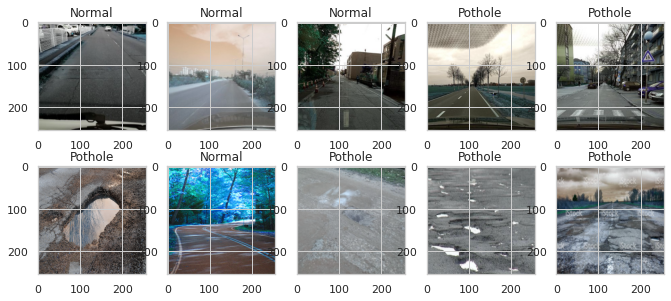

In [11]:
fig,ax=plt.subplots(2,5)
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
fig.set_size_inches(10,10)

for i in range(2):
    for j in range (5):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l][:])
        ax[i,j].set_title(Z[l])
        ax[i,j].set_aspect('equal')

Splitting the data into Training and Validation data

In [12]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,2)
print(Y)
X=np.array(X)

x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=1337)

np.random.seed(42)
rn.seed(42)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


Building the CNN model using RESNET

In [13]:
base_model=ResNet50(include_top=False, weights='imagenet',input_shape=(256,256,3), pooling='max')
base_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [14]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.20))
model.add(Dense(2048,activation='relu'))
model.add(Dense(1024,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(2,activation='softmax'))

In [15]:
epochs=50
batch_size=128
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=2, verbose=1)
base_model.trainable=True # setting the VGG model to be trainable.
model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 30,408,066
Trainable params: 30,354,946
No

In [16]:
History = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test,y_test))

Epoch 1/50
274/274 [==============================] - 142s 447ms/step - loss: 0.5758 - accuracy: 0.8236 - val_loss: 0.3239 - val_accuracy: 0.8929
Epoch 2/50
274/274 [==============================] - 122s 445ms/step - loss: 0.2835 - accuracy: 0.8924 - val_loss: 0.2838 - val_accuracy: 0.8785
Epoch 3/50
274/274 [==============================] - 122s 445ms/step - loss: 0.2112 - accuracy: 0.9136 - val_loss: 0.2742 - val_accuracy: 0.8778
Epoch 4/50
274/274 [==============================] - 122s 445ms/step - loss: 0.1449 - accuracy: 0.9361 - val_loss: 0.3051 - val_accuracy: 0.9018
Epoch 5/50
274/274 [==============================] - 122s 446ms/step - loss: 0.1051 - accuracy: 0.9546 - val_loss: 0.2861 - val_accuracy: 0.8833
Epoch 6/50
274/274 [==============================] - 122s 445ms/step - loss: 0.0796 - accuracy: 0.9671 - val_loss: 0.2883 - val_accuracy: 0.8867
Epoch 7/50
274/274 [==============================] - 122s 445ms/step - loss: 0.0659 - accuracy: 0.9732 - val_loss: 0.3091 -

In [18]:
loss, accuracy = model.evaluate(x_test, y_test)

print('Test accuracy: {:2.2f}%'.format(accuracy*100))

92/92 [==============================] - 11s 124ms/step - loss: 0.8033 - accuracy: 0.9008
Test accuracy: 90.08%


In [19]:
model.save('/content/drive/MyDrive/Project/model.h5')

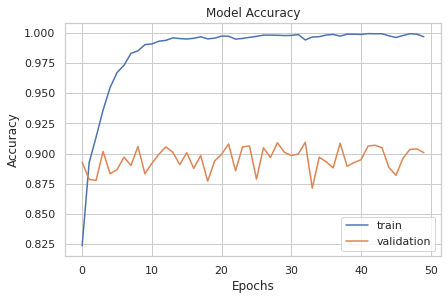

In [20]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

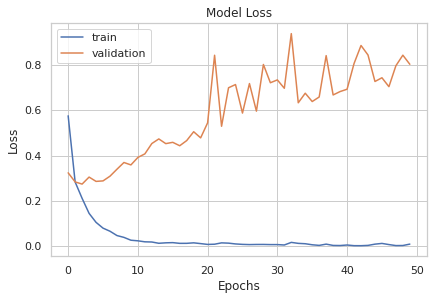

In [21]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [22]:
path = "/content/drive/MyDrive/Project/pothol_detection/Pothole_detection_test_data/Pothole"
files = os.listdir(path)
files

['296.jpg',
 '298.jpg',
 '295.jpg',
 '297.jpg',
 '310.jpg',
 '319.jpg',
 '307.jpg',
 '320.jpg',
 '309.jpg',
 '321.jpg',
 '322.jpg',
 '308.jpg']

  0%|          | 0/12 [00:00<?, ?it/s]

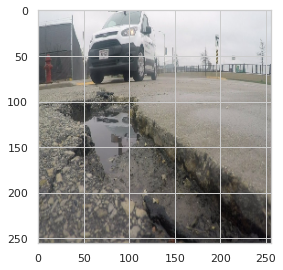

  8%|▊         | 1/12 [00:02<00:22,  2.01s/it]

Pothole Road


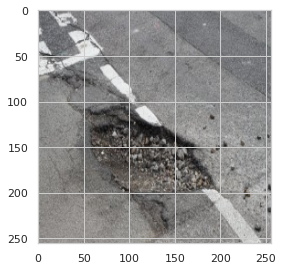

 17%|█▋        | 2/12 [00:02<00:10,  1.10s/it]

Pothole Road


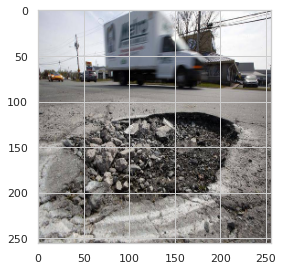

 25%|██▌       | 3/12 [00:02<00:07,  1.23it/s]

Pothole Road


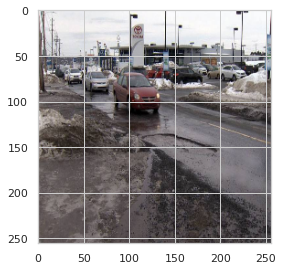

 33%|███▎      | 4/12 [00:03<00:05,  1.48it/s]

Pothole Road


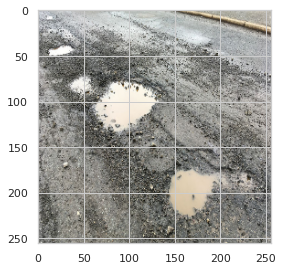

 42%|████▏     | 5/12 [00:03<00:04,  1.64it/s]

Pothole Road


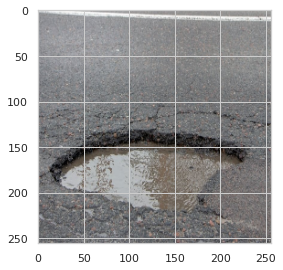

 50%|█████     | 6/12 [00:04<00:03,  1.76it/s]

Pothole Road


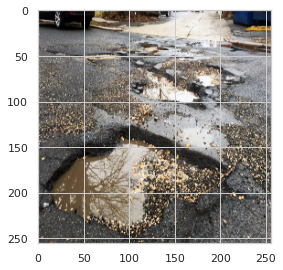

 58%|█████▊    | 7/12 [00:04<00:02,  1.88it/s]

Pothole Road


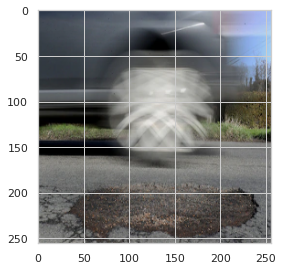

 67%|██████▋   | 8/12 [00:05<00:02,  1.89it/s]

Pothole Road


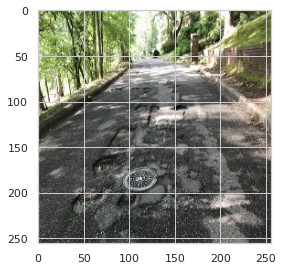

 75%|███████▌  | 9/12 [00:05<00:01,  1.92it/s]

Pothole Road


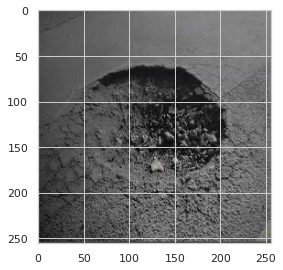

 83%|████████▎ | 10/12 [00:06<00:01,  1.95it/s]

Pothole Road


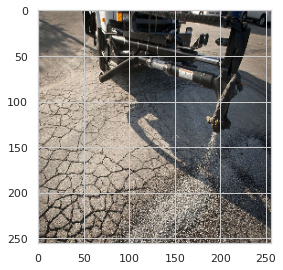

 92%|█████████▏| 11/12 [00:06<00:00,  1.92it/s]

Pothole Road


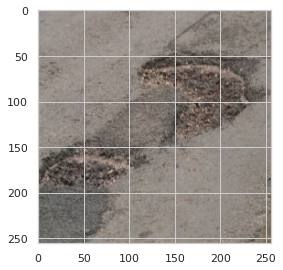

100%|██████████| 12/12 [00:07<00:00,  1.62it/s]

Pothole Road


In [23]:
for i in tqdm(files):
    pth = os.path.join(path,i)
    X = cv2.imread(pth,cv2.IMREAD_COLOR)
    X = cv2.resize(X,(256,256))
    plt.figure()
    plt.imshow(X[:,:,::-1]) 
    plt.show()  

    X = np.array(X)
    X = np.expand_dims(X, axis=0)

    y_pred = np.round(model.predict(X))
    if y_pred[0][0] == 1:
        print("Normal Road")
    else:
        print("Pothole Road")

In [24]:
path = "/content/drive/MyDrive/Project/pothol_detection/Pothole_detection_test_data/Normal"
files = os.listdir(path)
files

['340.jpg',
 '339.jpg',
 '351.jpg',
 '349.jpg',
 '350.jpg',
 '338.jpg',
 '337.jpg',
 '352.jpg',
 '341.jpg']

  0%|          | 0/9 [00:00<?, ?it/s]

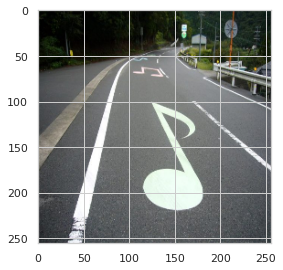

 11%|█         | 1/9 [00:00<00:03,  2.16it/s]

Normal Road


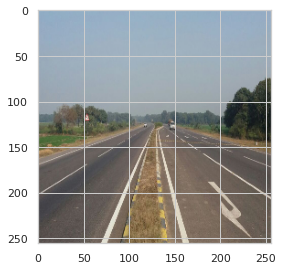

 22%|██▏       | 2/9 [00:01<00:04,  1.45it/s]

Normal Road


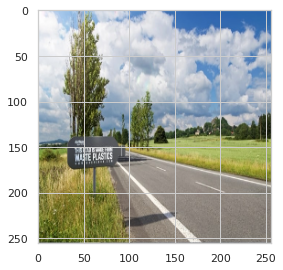

 33%|███▎      | 3/9 [00:01<00:03,  1.70it/s]

Normal Road


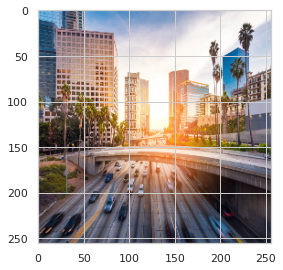

 44%|████▍     | 4/9 [00:02<00:03,  1.64it/s]

Normal Road


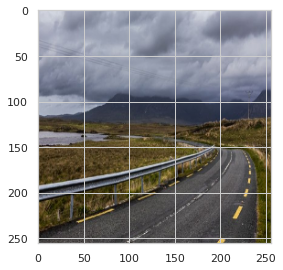

 56%|█████▌    | 5/9 [00:02<00:02,  1.73it/s]

Normal Road


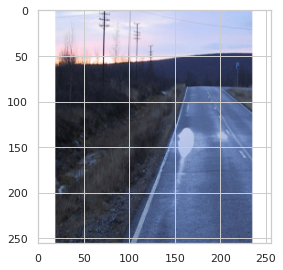

 67%|██████▋   | 6/9 [00:03<00:01,  1.85it/s]

Normal Road


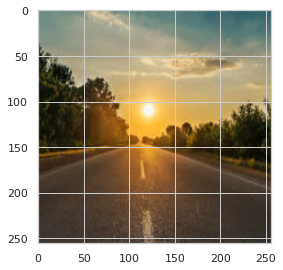

 78%|███████▊  | 7/9 [00:03<00:01,  1.92it/s]

Normal Road


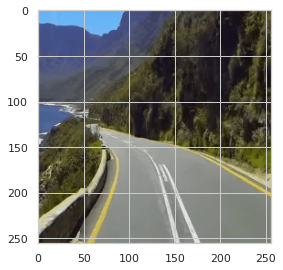

 89%|████████▉ | 8/9 [00:04<00:00,  1.97it/s]

Normal Road


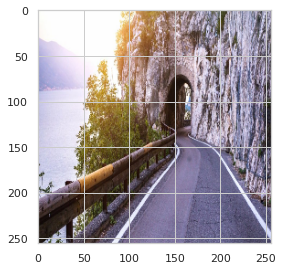

100%|██████████| 9/9 [00:04<00:00,  1.85it/s]

Normal Road


In [25]:
for i in tqdm(files):
    pth = os.path.join(path,i)
    X = cv2.imread(pth,cv2.IMREAD_COLOR)
    X = cv2.resize(X,(256,256))
    plt.figure()
    plt.imshow(X[:,:,::-1]) 
    plt.show()  

    X = np.array(X)
    X = np.expand_dims(X, axis=0)

    y_pred = np.round(model.predict(X))
    if y_pred[0][0] == 1:
        print("Normal Road")
    else:
        print("Pothole Road")

In [26]:
path = "/content/drive/MyDrive/Project/pothol_detection/Pothole_detection_test_data/Mix_images"
files = os.listdir(path)
files

['143.jpg',
 '138.jpg',
 '142.jpg',
 '141.jpg',
 '139.jpg',
 '140.jpg',
 '93.jpg',
 '92.jpg',
 '89.jpg',
 '91.jpg',
 '95.jpg',
 '90.jpg',
 '94.jpg']

  0%|          | 0/13 [00:00<?, ?it/s]

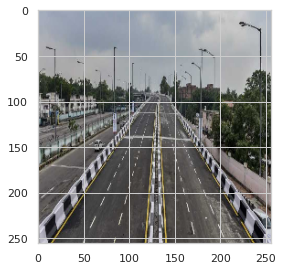

  8%|▊         | 1/13 [00:00<00:05,  2.20it/s]

Normal Road


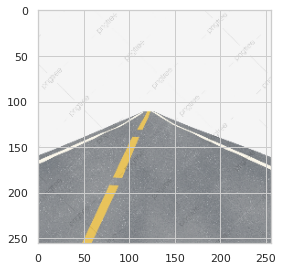

 15%|█▌        | 2/13 [00:00<00:05,  2.12it/s]

Normal Road


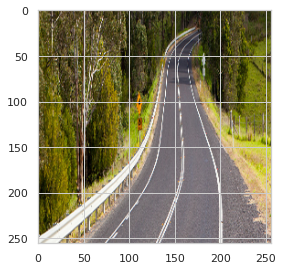

 23%|██▎       | 3/13 [00:01<00:05,  1.85it/s]

Normal Road


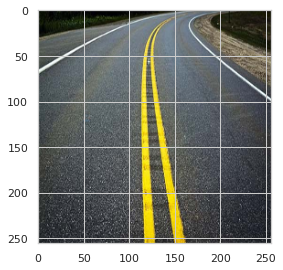

 31%|███       | 4/13 [00:02<00:04,  1.92it/s]

Normal Road


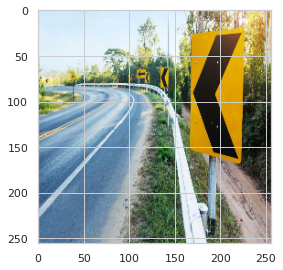

 38%|███▊      | 5/13 [00:02<00:03,  2.01it/s]

Normal Road


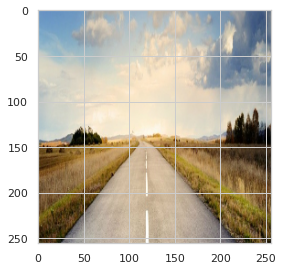

 46%|████▌     | 6/13 [00:03<00:03,  1.79it/s]

Normal Road


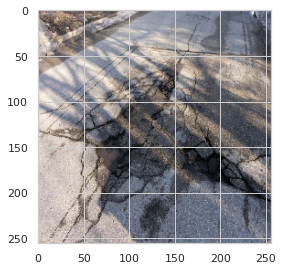

 54%|█████▍    | 7/13 [00:03<00:03,  1.87it/s]

Pothole Road


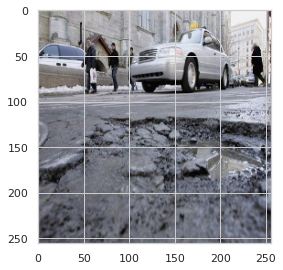

 62%|██████▏   | 8/13 [00:04<00:02,  1.95it/s]

Pothole Road


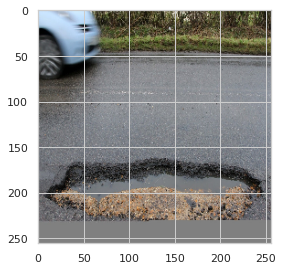

 69%|██████▉   | 9/13 [00:04<00:02,  1.99it/s]

Pothole Road


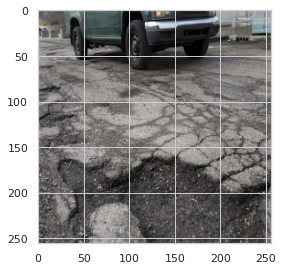

 77%|███████▋  | 10/13 [00:05<00:01,  1.98it/s]

Pothole Road


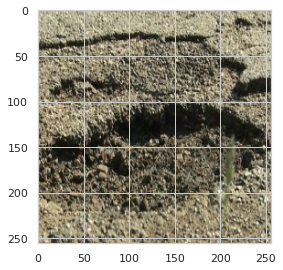

 85%|████████▍ | 11/13 [00:07<00:01,  1.02it/s]

Pothole Road


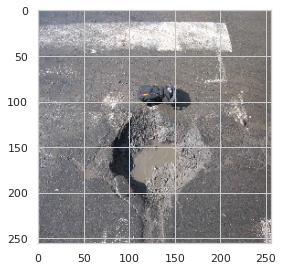

 92%|█████████▏| 12/13 [00:07<00:00,  1.21it/s]

Pothole Road


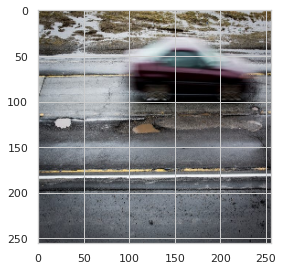

100%|██████████| 13/13 [00:08<00:00,  1.59it/s]

Pothole Road


In [27]:
for i in tqdm(files):
    pth = os.path.join(path,i)
    X = cv2.imread(pth,cv2.IMREAD_COLOR)
    X = cv2.resize(X,(256,256))
    plt.figure()
    plt.imshow(X[:,:,::-1]) 
    plt.show()  

    X = np.array(X)
    X = np.expand_dims(X, axis=0)

    y_pred = np.round(model.predict(X))
    if y_pred[0][0] == 1:
        print("Normal Road")
    else:
        print("Pothole Road")